In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
df_ratings = pd.read_csv('ml-latest-small/ratings.csv')
df_movies = pd.read_csv('ml-latest-small/movies.csv')

In [3]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
df_to_plot = df_ratings['movieId'].value_counts().reset_index()
df_to_plot.columns = ['movieId', 'count']
df_to_plot['cumulative_volume'] = df_to_plot['count'].cumsum()
df_to_plot['percent_of_total_volume'] = df_to_plot['cumulative_volume']/df_to_plot['count'].sum()

C:\Users\Vadim\AppData\Local\Temp/ipykernel_14984/2663117621.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0%}'.format(x) for x in ax2.get_yticks()])


Text(0.5, 1.0, 'Ratings long tail plot')

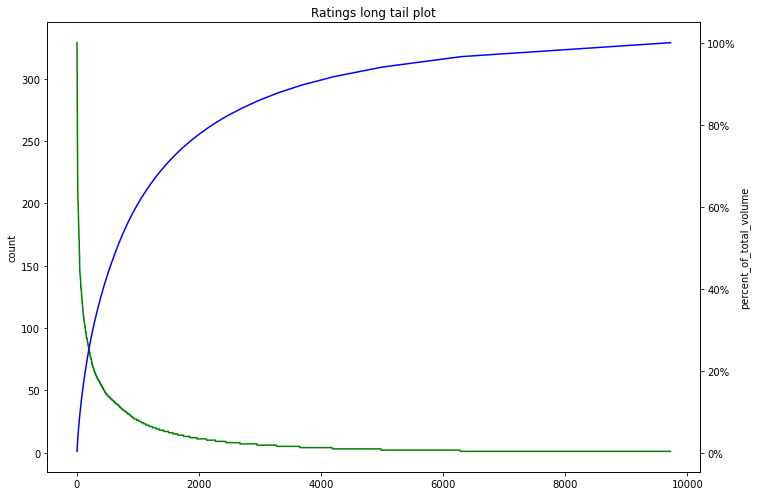

In [7]:
%matplotlib inline
fig, ax2 = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.lineplot(data=df_to_plot['count'], color="g")
ax2 = plt.twinx()
sns.lineplot(data=df_to_plot['percent_of_total_volume'], color="b", ax=ax2)
ax2.set_yticklabels(['{:,.0%}'.format(x) for x in ax2.get_yticks()])
ax2.set_title('Ratings long tail plot')

## Train/Test split

In [8]:
df_ratings = df_ratings.merge(df_movies[['movieId', 'title']],how='left', on='movieId')

In [9]:
train_data, test_data = train_test_split(df_ratings, test_size = 0.25, random_state=57)

In [10]:
test_res = test_data.copy().groupby('userId', as_index=False)['title'].agg({'actual': (lambda x: list(set(x)))})
test_res = test_res.set_index("userId")

In [11]:
train_data_ui = train_data.pivot_table(index=['userId'], columns=['title'], values='rating')
test_data_ui = test_data.pivot_table(index=['userId'], columns=['title'], values='rating')

## Simple rating prediction. MSE

In [12]:
print("Number of movies in Test: {}".format(len(set(test_data.movieId))))
print("Interseption of movies in Train and Test: {}".format(len(set.intersection(set(test_data.movieId), set(train_data.movieId)))))

Number of movies in Test: 5644
Interseption of movies in Train and Test: 4693


In [13]:
mean_rating = pd.DataFrame(train_data_ui.mean(axis=0), columns=['pred_rating']).reset_index()

In [14]:
test_data = test_data.merge(mean_rating, how='left', on='title')

In [17]:
test_data.head()

,userId,movieId,rating,timestamp,title,pred_rating
0,414,2433,2.0,961436616,"Civil Action, A (1998)",3.062500
1,380,91500,3.0,1494708626,The Hunger Games (2012),3.500000
2,462,1261,4.0,1138343577,Evil Dead II (Dead by Dawn) (1987),3.903846
3,597,2505,2.0,940420065,8MM (1999),2.966667
4,232,53127,0.5,1209068728,Bug (2007),3.666667


In [19]:
def mse(actual, pred) -> float:
    mse = np.square(np.subtract(actual, pred)).mean()
    return mse

In [20]:
mse = mse(test_data.rating, test_data.pred_rating)

In [21]:
mse

0.9522521320877634

In [25]:
np.sqrt(mse)

0.9758340699564467

## Collaborative filtering based on Pearson similarity

In [26]:
cf_recs = []

In [27]:
%%time
corr_matrix = train_data_ui.corr(method='pearson', min_periods=100)

Wall time: 26.4 s


In [28]:
%%time
for i in test_res.index:
    user_ratings = train_data_ui.loc[i].dropna()
    simCandidates = pd.Series()

    for j in range(0, len(user_ratings.index)): # Идем по списку всех фильмов оцененных пользвателем
        sims = corr_matrix[user_ratings.index[j]].dropna() # Извлекаем фильмы, похожие на оцененные данным юзером (1)
        sims = sims.map(lambda x: x * user_ratings[j]) # Умножаем корреляцию на оценку пользователя по фильму
        simCandidates = simCandidates.append(sims) # Добавляем индекс в список сравниваемых кандидатов

    simCandidates = simCandidates.groupby(simCandidates.index).sum()
    simCandidates.sort_values(inplace = True, ascending = False)

    # выбираем фильмы, которые пользователь еще не смотрел
    intersection_set = set.intersection(set(simCandidates.index), set(user_ratings.index))
    not_watched = list(set(simCandidates.index) - set(user_ratings.index))
    colab_predictions = simCandidates[not_watched].sort_values(ascending = False).head(10).index.to_list()
    cf_recs.append(colab_predictions)

<timed exec>:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Wall time: 42 s


In [29]:
test_res['colab_predictions'] = cf_recs
test_res.head()

,actual,colab_predictions
userId,,
1,"[Young Frankenstein (1974), So I Married an Ax...","[Shawshank Redemption, The (1994), Forrest Gum..."
2,[Talladega Nights: The Ballad of Ricky Bobby (...,[]
3,"[Fast Times at Ridgemont High (1982), Dangerou...",[]
4,"[Moulin Rouge (2001), Swingers (1996), Crumb (...",[Star Wars: Episode VI - Return of the Jedi (1...
5,"[In the Name of the Father (1993), Dead Man Wa...","[Silence of the Lambs, The (1991), Forrest Gum..."


## Popularity recommender

In [30]:
#make recommendations for all members in the test data
popularity_recs = train_data.title.value_counts().head(10).index.tolist()

pop_recs = []
for user in test_res.index:
    pop_predictions = popularity_recs
    pop_recs.append(pop_predictions)
        
test_res['pop_predictions'] = pop_recs
test_res.head()

,actual,colab_predictions,pop_predictions
userId,,,
1,"[Young Frankenstein (1974), So I Married an Ax...","[Shawshank Redemption, The (1994), Forrest Gum...","[Shawshank Redemption, The (1994), Forrest Gum..."
2,[Talladega Nights: The Ballad of Ricky Bobby (...,[],"[Shawshank Redemption, The (1994), Forrest Gum..."
3,"[Fast Times at Ridgemont High (1982), Dangerou...",[],"[Shawshank Redemption, The (1994), Forrest Gum..."
4,"[Moulin Rouge (2001), Swingers (1996), Crumb (...",[Star Wars: Episode VI - Return of the Jedi (1...,"[Shawshank Redemption, The (1994), Forrest Gum..."
5,"[In the Name of the Father (1993), Dead Man Wa...","[Silence of the Lambs, The (1991), Forrest Gum...","[Shawshank Redemption, The (1994), Forrest Gum..."


## Random recommender

In [31]:
#make recommendations for all members in the test data

ran_recs = []
for user in test_res.index:
    random_predictions = df_ratings.title.sample(10).values.tolist()
    ran_recs.append(random_predictions)
        
test_res['rand_predictions'] = ran_recs
test_res.head()

,actual,colab_predictions,pop_predictions,rand_predictions
userId,,,,
1,"[Young Frankenstein (1974), So I Married an Ax...","[Shawshank Redemption, The (1994), Forrest Gum...","[Shawshank Redemption, The (1994), Forrest Gum...","[Bad Boys (1995), Jumanji (1995), American Wer..."
2,[Talladega Nights: The Ballad of Ricky Bobby (...,[],"[Shawshank Redemption, The (1994), Forrest Gum...","[Truman Show, The (1998), Hacksaw Ridge (2016)..."
3,"[Fast Times at Ridgemont High (1982), Dangerou...",[],"[Shawshank Redemption, The (1994), Forrest Gum...","[Buffalo '66 (a.k.a. Buffalo 66) (1998), 40-Ye..."
4,"[Moulin Rouge (2001), Swingers (1996), Crumb (...",[Star Wars: Episode VI - Return of the Jedi (1...,"[Shawshank Redemption, The (1994), Forrest Gum...","[Net, The (1995), Star Trek II: The Wrath of K..."
5,"[In the Name of the Father (1993), Dead Man Wa...","[Silence of the Lambs, The (1991), Forrest Gum...","[Shawshank Redemption, The (1994), Forrest Gum...","[Before and After (1996), Goodfellas (1990), G..."


## Catalog Coverage

In [32]:
def catalog_coverage(predicted, catalog, k: int) -> float:
    '''
    k: integer
        The number of observed recommendation lists
        which randomly choosed in our offline setup
    '''
    sampling = random.choices(predicted, k=k)
    predicted_flattened = [p for sublist in sampling for p in sublist]
    L_predictions = len(set(predicted_flattened))
    catalog_coverage = round(L_predictions/(len(catalog)*1.0),3)
    return catalog_coverage

In [33]:
catalog = df_ratings.title.unique().tolist()
cf_cat_coverage = catalog_coverage(cf_recs, catalog, 100)
pop_cat_coverage = catalog_coverage(pop_recs, catalog, 100)
random_cat_coverage = catalog_coverage(ran_recs, catalog, 100)

In [34]:
print("Catalog coverage (cf): {}".format(cf_cat_coverage))
print("Catalog coverage (popular): {}".format(pop_cat_coverage))
print("Catalog coverage (random): {}".format(random_cat_coverage))

Catalog coverage (cf): 0.001
Catalog coverage (popular): 0.001
Catalog coverage (random): 0.076


## User coverage

In [38]:
def user_coverage(predicted) -> float:
    """
    Computes the share of test users to whom we were able to provide recommendation.
    Parameters
    ----------
    predicted : a list of lists
        Ordered predictions
        example: [['X', 'Y', 'Z'], ['X', 'Y', 'Z']]
    Returns
    ----------
    user_coverage:
        Share of test users in predicted list to whom we provided recommendation
        rounded to 2 decimal places
    """
    
    L_predictions = sum([1 if len(i) > 0 else 0 for i in predicted])
    user_coverage = round(L_predictions/(len(predicted)*1.0),2)
    
    return user_coverage

In [39]:
print("User coverage (cf): {}".format(user_coverage(cf_recs)))
print("User coverage (popular): {}".format(user_coverage(pop_recs)))
print("User coverage (random): {}".format(user_coverage(ran_recs)))

User coverage (cf): 0.82
User coverage (popular): 1.0
User coverage (random): 1.0


### Novelty

In [40]:
def novelty(predicted, pop, u: int, n: int) -> (float, list):
    """
    Computes the novelty for a list of recommendations
    Parameters
    ----------
    predicted : a list of lists
    pop: dictionary
        A dictionary of all items alongside of its occurrences counter in the training data
        example: {1198: 893, 1270: 876, 593: 876, 2762: 867}
    u: integer
        The number of users in the training data
    n: integer
        The length of recommended lists per user
    Returns
    ----------
    novelty:
        The novelty of the recommendations in system level
    mean_self_information:
        The novelty of the recommendations in recommended top-N list level
    ----------
    Metric definition: https://arxiv.org/pdf/0808.2670.pdf
    """
    mean_self_information = []
    k = 0
    for sublist in predicted:
        self_information = 0
        k += 1
        for i in sublist:
            self_information += np.sum(-np.log2(pop[i]/u))
        mean_self_information.append(self_information/n)
    novelty = sum(mean_self_information)/k
    return novelty, mean_self_information

In [41]:
nov = df_ratings.title.value_counts()
pop = dict(nov)
users = df_ratings["userId"].value_counts()

In [42]:
random_novelty,random_mselfinfo_list = novelty(ran_recs, pop, len(users), 10)
pop_novelty,pop_mselfinfo_list = novelty(pop_recs, pop, len(users), 10)
cf_novelty,cf_mselfinfo_list = novelty(cf_recs, pop, len(users), 10)

In [43]:
print("Novelty (cf): {}".format(cf_novelty))
print("Novelty (popular): {}".format(pop_novelty))
print("Novelty (random): {}".format(random_novelty))

Novelty (cf): 0.31385875843373223
Novelty (popular): 1.2007395088965802
Novelty (random): 4.3404322606026735


### Hitrate@k

Напомним, что это сколько верных рекомендаций мы предложили пользователю u на заданном количестве рекомендаций.

In [61]:
def hitrate_k(predicted, actual, k: int) -> int:
    """
    Computes the average number of correct reccommendations for a user
    Parameters
    ----------
    predicted : a list of lists with recommendations
    actual: list of lists with actual movie watches
    k: integer
        The maximum number of recommendations in a list
    Returns
    ----------
    hitrate_k:
        The average number of correct recommendations for a user
    L_intersect"""
    
    L_intersect = 0
    for i in predicted.index:
        pred = predicted.loc[i][:k]
        if len(set.intersection(set(pred), set(actual.loc[i])))>1: L_intersect +=1
        
    hitrate_k = L_intersect/len(predicted.index)
    ######################
    # WRITE YOUR CODE HERE
    ######################
    
    return hitrate_k

In [62]:
cf_hitrate_k = hitrate_k(test_res.colab_predictions, test_res.actual, 10)
pop_hitrate_k = hitrate_k(test_res.pop_predictions, test_res.actual, 10)
random_hitrate_k = hitrate_k(test_res.rand_predictions, test_res.actual, 10)

In [63]:
print("Hitrate_k (cf): {}".format(cf_hitrate_k))
print("Hitrate_k (popular): {}".format(pop_hitrate_k))
print("Hitrate_k (random): {}".format(random_hitrate_k))

Hitrate_k (cf): 0.20361247947454844
Hitrate_k (popular): 0.30870279146141216
Hitrate_k (random): 0.042692939244663386
